In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime as dt
from datetime import date

In [2]:
#df_new=pd.read_csv('optimized_estates.csv')

In [2]:
df=pd.read_csv('portal-offers-05.06.2020.csv')

/home/paulina_cieslinska/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (10,11,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
geo=pd.read_csv('population.csv')

In [4]:
df2=df[(df.main_type_name == 'mieszkanie') & (df.transaction_name == 'sprzedaż')]
#df.loc[[df['main_type_name']=='dom' or df['main_type_name']== 'mieszkanie']]

In [5]:
pd.set_option('display.max_columns', None)

In [6]:
df2.drop(columns=['portal_id','main_type_id','main_type_name','transaction','transaction_name','id','description','location_district_name','raw_data','location_province_name','building_floornumber','portal_name','add_date','update_date','last_scan_date','source_add_date','source_update_date','location_precinct_name','location_street_name'],inplace=True)

/home/paulina_cieslinska/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [7]:
df2['location_latitude'] = pd.to_numeric(df2.location_latitude, errors='coerce')

/home/paulina_cieslinska/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [8]:
df2['location_longitude'] = pd.to_numeric(df2.location_longitude, errors='coerce')

/home/paulina_cieslinska/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [9]:
df2[['location_latitude','location_longitude']] = df2[['location_latitude','location_longitude']].replace(',','.')

/home/paulina_cieslinska/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [10]:
df3=df2[(df2['location_latitude'].notnull()) & (df2['location_longitude'].notnull())]

In [11]:
var_house=df3[['price', 'area_total', 'price_permeter']].apply(pd.to_numeric, errors='coerce')

In [12]:
df5=df3.merge(var_house, left_index=True, right_index=True)

In [13]:
df6=df5.drop(columns=['price_x','area_total_x','price_permeter_x'])

In [14]:
df6.area_total_y=np.where(df6.area_total_y.isnull(),df6.price_y/df6.price_permeter_y,df6.area_total_y)

In [15]:
df6.price_permeter_y=np.where(df6.price_permeter_y.isnull(),df6.price_y/df6.area_total_y,df6.price_permeter_y)

In [16]:
#jeżeli brak piętra to założenie że na parterze, bądź parterowy dom
df6.apartment_floor.fillna(0,inplace=True)
#jeżeli 'apartment_room' to liczba pokoi a nie wszystkich pomieszczeń
df6.apartment_room_number.fillna(1,inplace=True)

In [17]:
convert_dict = {'apartment_room_number': int,
                'apartment_floor': int
               } 

In [18]:
df7=df6.astype(convert_dict)

In [19]:
ilo=df7.building_year.isnull().sum()/df7.building_year.sum()
ilo
#stanowi to 0.5% więc można usunąc te wyniki bądź spróbować znaleźć, poprzez kmean albo inny model jaki powinen być wiek budynku
#na ten moment ja wyrzucam
df8 = df7[df7.building_year.notnull()]
# analiza tylko tych obiektów, które posiadają cene
df9 = df8[df8.price_y.notnull()]

In [20]:
def rm_out(df,columns=None):
    if columns:
        columns = columns
    else:
        columns = df.columns
        
    df_out = df.copy()
    for c in columns:
        q1 = df[c].quantile(0.25)
        q3 = df[c].quantile(0.75)
        IRQ = q3 - q1
        df_out = df_out.loc[ (df[c] <= q3 + 1.5 * IRQ) & (df[c] >= q1 - 1.5 * IRQ) ]
        
    df_out.index = range(len(df_out))
    return df_out

In [21]:
col=['price_y','apartment_floor','area_total_y']
df_clean=rm_out(df9,col)

In [22]:
miasta=pd.DataFrame(df_clean.location_city_name.str.capitalize())

In [23]:
merget_df=df_clean.merge(miasta, left_index=True,right_index=True)
merget_df.drop(['location_city_name_x'], axis=1,inplace=True)
merget_df.rename(columns={'location_city_name_y':'location_city_name','price_y':'price','area_total_y':'area_total'}, inplace=True)

In [24]:
dane_all=merget_df.merge(geo,left_on='location_city_name',right_on='Miasto',how='inner')

In [25]:
dane_all.Populacja = [n.replace(' ','') for n in dane_all.Populacja]

In [26]:
populacja=pd.DataFrame(dane_all.Populacja.astype(int))
dane_sum=dane_all.merge(populacja,left_index=True,right_index=True)
dane_sum.drop(columns=['Populacja_x'],axis=1, inplace=True)

In [27]:
# rozmiar_miast={'Warszawa':'najwieksze_miasta','Krakow':'najwieksze_miasta','Łódź':'najwieksze_miasta','Wrocław':'najwieksze_miasta','Poznań':'najwieksze_miasta',
#                'Gdańsk':'wieksze_miasta','Szczecin':'wieksze_miasta','Bydgoszcz':'wieksze_miasta','Lublin':'wieksze_miasta','Białystok':'wieksze_miasta','Katowice':'wieksze_miasta',
#                'Gdynia':'duze_miasta','Częstochowa':'duze_miasta','Radom':'duze_miasta','Toruń':'duze_miasta','Sosnowiec':'duze_miasta','Kielce':'duze_miasta','Rzeszów':'duze_miasta','Gliwice':'duze_miasta','Zabrze':'duze_miasta',
#                 'Olsztyn':'duze_miasta','Bielsko-Biała':'duze_miasta','Bytom':'duze_miasta','Zielona Góra':'duze_miasta','Rybnik':'duze_miasta','Ruda Śląska':'duze_miasta','Opole':'duze_miasta','Tychy':'duze_miasta','Gorzów Wielkopolski':'duze_miasta',
#                 'Płock':'duze_miasta','Dąbrowa Górnicza':'duze_miasta','Elbląg':'duze_miasta','Wałbrzych':'duze_miasta','Włocławek':'duze_miasta', 'Tarnów':'duze_miasta','Chorzów':'duze_miasta', 'Koszalin':'duze_miasta','Kalisz':'duze_miasta'}
# #pozostałe to będą małe_miasta
        

In [28]:
city_size=[]

for num in dane_sum['Populacja_y']:
    if num >=500000:
        city_size.append('najwieksze_miasta')
    elif num <500000 and num >=250000:
        city_size.append('wieksze_miasta')
    elif num <250000 and num >=100000:
        city_size.append('duze_miasta')
    elif num <100000 and num >=50000:
        city_size.append('srednie_miasta')
    elif num <50000 and num >=25000:
        city_size.append('wieksze_miasta')
    else:
        city_size.append('pozostale')

dane_sum['city_size']=city_size

In [29]:
dane_sum.drop(columns=['Unnamed: 0','index','Miasto','Powiat','Województwo','Współrzędne Geograficzne','location_city_name','Kobiety','Mężczyźni'],axis=1, inplace=True)

In [30]:
#zmiana zmiennych kategotycznych na liczbowe
data=pd.get_dummies(dane_sum,columns=['city_size'])
data.dropna(inplace=True)

In [31]:
#statistic data

In [33]:
cols = data.drop(columns=['price']).shape[1]
feature_data=data.drop(columns=['price'])

In [35]:
import math

In [47]:
import matplotlib.pyplot as plt

def drawAllHist(data, histNumInRow, res):
    """
    Funkcja rysująca histogramy z podanych danych w postaci siatki wykresów
    :param data: dane w postaci np.array wczytane z sklearn
    :param histNumInRow: wartość całkowita określająca ilość histogramów w jednym rzędzie
    :param res: rozdzielczość histogramów
    """
    # ile mamy kolumn w danych
    cols = data.shape[1]
    #dataset z waznymi kolumnami
    feature_data=data.drop(columns=['price'])
    # liczymy ile ma być rzędów
    howManyHistRows = math.ceil(cols / histNumInRow)
    # tworzymy kontener na wykresy
    fig, axs = plt.subplots(howManyHistRows, histNumInRow, figsize=(20, 20))
    # rysujemy, idziemy po rzędach i rysujemy w każdej kolumnie
    for r in range(histNumInRow):
        for c in range(howManyHistRows):
            # liczymy indeks kolumny w danych
            idx = int(r * histNumInRow + c)
            # sprawdzamy czy tyle w ogóle ich mamy
            if idx < cols:
                axs[c,r].set_title(data.columns[idx])
                axs[c,r].hist(data.values[:, idx], res)
            else:
                break
    plt.show()

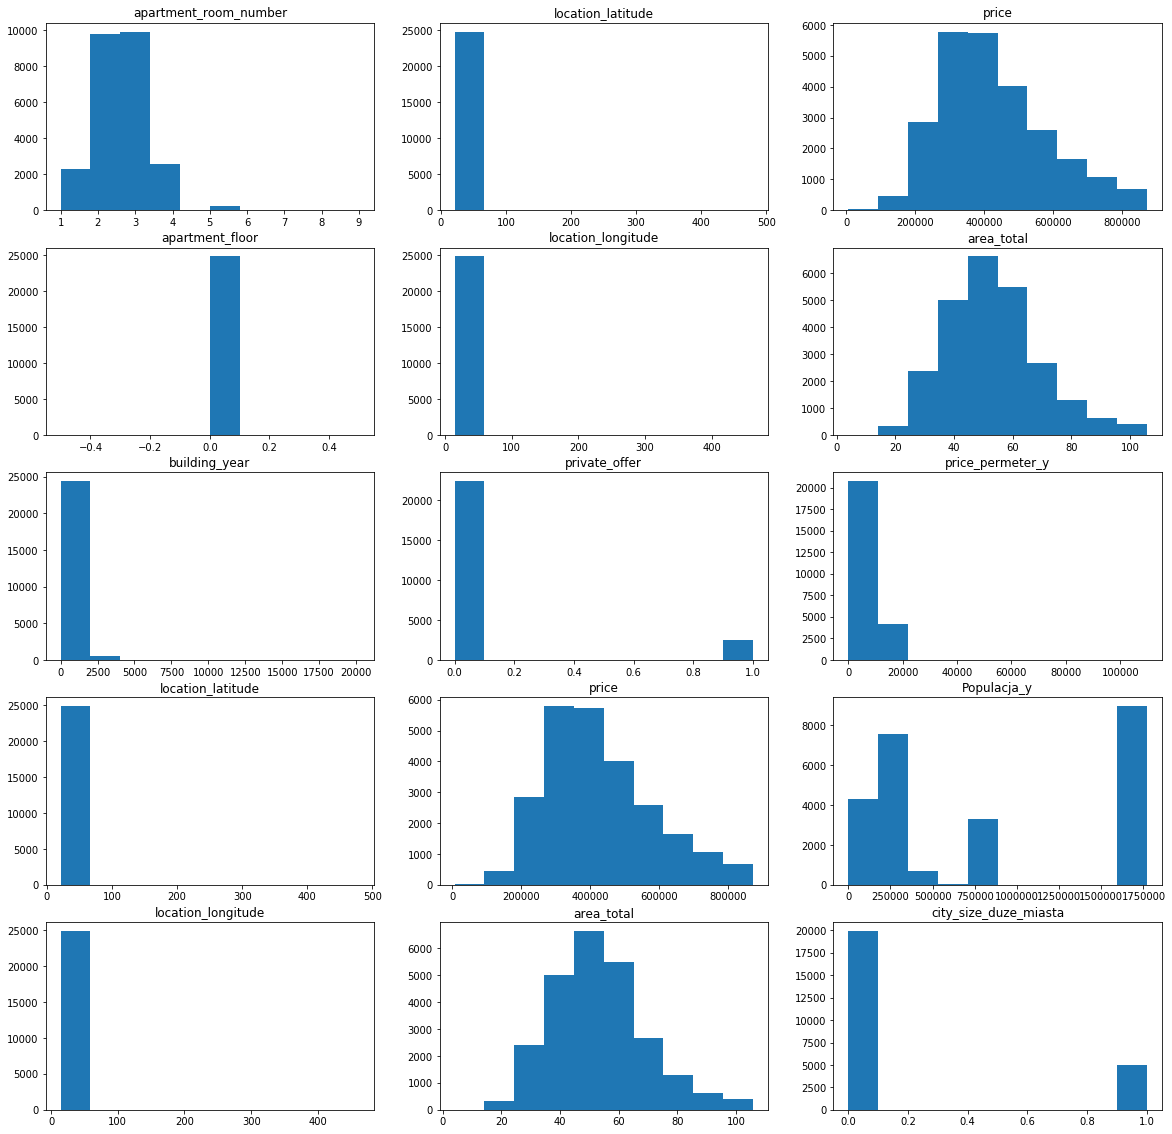

In [48]:
drawAllHist(data, 3, 10)

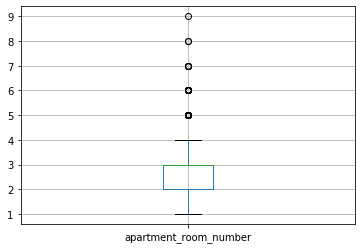

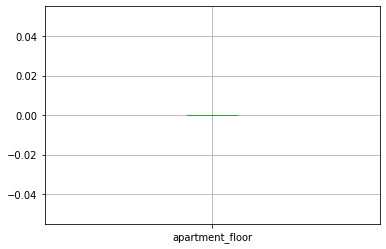

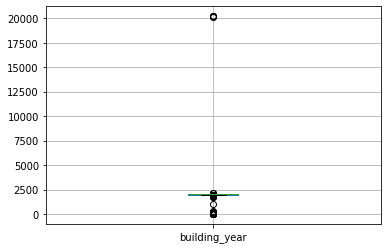

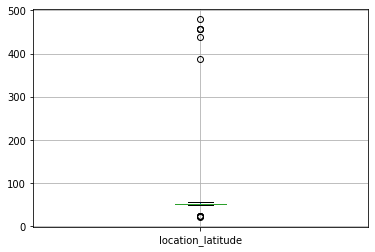

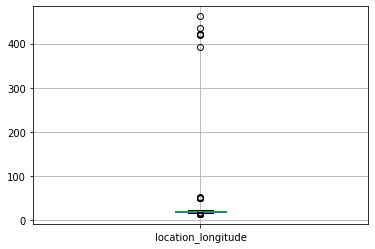

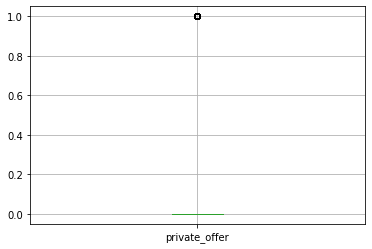

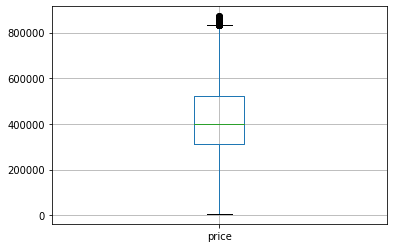

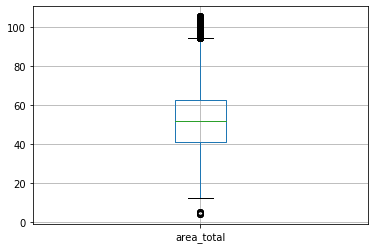

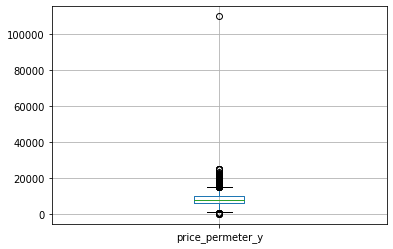

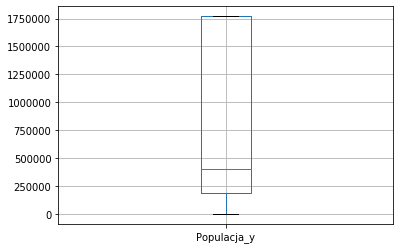

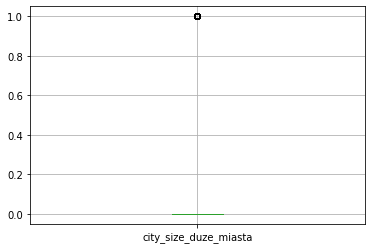

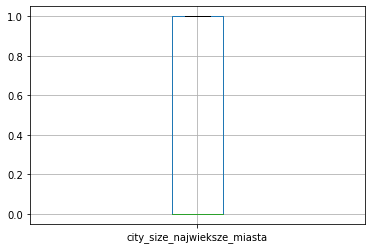

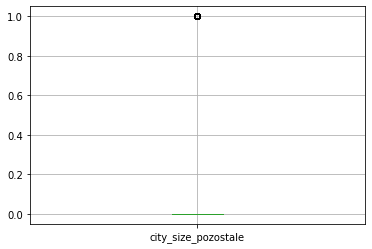

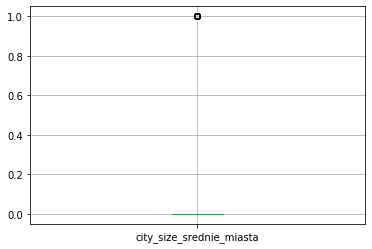

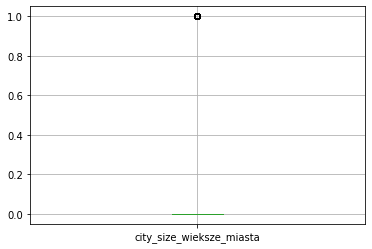

In [49]:
for i in data.columns:
    data.boxplot(column=i)
    plt.show()

In [34]:
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

In [35]:
# recent_date = data['apartment_floor'].max()
# data[data['apartment_floor'] == recent_date]

In [36]:
#standaryzacja danych

In [37]:
scalar = MinMaxScaler().fit(data)
standard=scalar.transform(data)
#taki uklad może być jak robimy fit. na całym zbiorze danych


In [38]:
from sklearn.model_selection import train_test_split

In [93]:
X=data.drop(['price'],axis=1)
Y=data['price'].values

In [103]:
train_x, test_x, train_y, test_y  = train_test_split(X,Y, test_size =0.2, random_state=123)

In [41]:
#sprawdzenie istotności zmiennych na model, metodą bootsrapingu
import xgboost as xgb

xg_reg = xgb.XGBRegressor(objective="reg:squarederror", 
                          seed=123, booster="gbtree")
xg_reg.fit(train_x, train_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=123, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=123, subsample=1,
             tree_method=None, validate_parameters=False, verbosity=None)

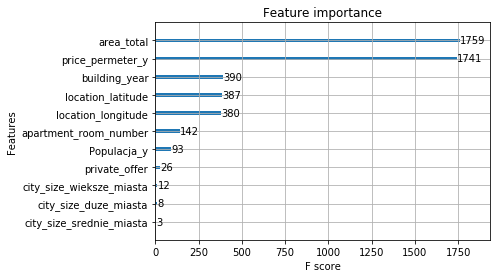

In [42]:
xgb.plot_importance(xg_reg,max_num_features = 15)

na podstawie powyższego wzięto do analizy tylko 10 pierwszych rekordów

In [166]:
# dane pod modele

**regresja wielomianowa**

In [44]:
from sklearn.metrics import r2_score

In [45]:
from statsmodels.formula.api import ols

In [55]:
import statsmodels.api as sm

In [101]:
list_of_responses = list(X.columns)

# list of models
models = []
formula='price ~'
for i, resp in enumerate(list_of_responses):
    if i==0:
        formula += resp 
    else:
        formula+=' + '+resp
    models.append(sm.OLS.from_formula(formula, data).fit())
        
#     models.summary()

In [102]:
for i in range(0,len(models)):
    print(models[i].summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     3845.
Date:                Thu, 02 Jul 2020   Prob (F-statistic):               0.00
Time:                        18:42:05   Log-Likelihood:            -3.3067e+05
No. Observations:               24862   AIC:                         6.613e+05
Df Residuals:                   24860   BIC:                         6.614e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              2.551e+

/home/paulina_cieslinska/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1755: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/home/paulina_cieslinska/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/home/paulina_cieslinska/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/paulina_cieslinska/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/paulina_cieslinska/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.292
Method:                 Least Squares   F-statistic:                     1710.
Date:                Thu, 02 Jul 2020   Prob (F-statistic):               0.00
Time:                        18:42:05   Log-Likelihood:            -3.2816e+05
No. Observations:               24862   AIC:                         6.563e+05
Df Residuals:                   24855   BIC:                         6.564e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               4.47e+

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                 1.856e+04
Date:                Thu, 02 Jul 2020   Prob (F-statistic):               0.00
Time:                        18:42:06   Log-Likelihood:            -3.0485e+05
No. Observations:               24862   AIC:                         6.097e+05
Df Residuals:                   24850   BIC:                         6.098e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In [140]:
best = 0
best_model = {}
for i in range(0,len(models)):
    r2 = models[i].rsquared
    if r2 > best:
        best = r2
        best_model[i] =r2
        best_model2=f"score: {r2} dla {i}"
        print(best_model2)
       

score: 0.13394210149658115 dla 0
score: 0.13406770176018556 dla 2
score: 0.13423104197788127 dla 3
score: 0.15077779576971884 dla 4
score: 0.15314799063621398 dla 5
score: 0.2921765232028761 dla 6
score: 0.884265766712742 dla 7
score: 0.8906442365692727 dla 8
score: 0.8909947277897035 dla 9
score: 0.8911918667639454 dla 10
score: 0.8914792787827779 dla 11
score: 0.8915581349309153 dla 12
score: 0.8915581349309154 dla 13


In [144]:
best_number=max(best_model.items(), key=operator.itemgetter(1))[0]

13

In [188]:
features = []

for i, fea in enumerate(list_of_responses):
    if i<best_number:
        features.append(fea)
        #features += fea 
    else:
        break

In [189]:
#use columns from 'features'

In [196]:
data_feature=pd.DataFrame(data[features])

In [202]:
#teaching model on data_feature

In [203]:
x=data_feature
y=data['price'].values
x_train, x_test, y_train_y, y_test  = train_test_split(x,y, test_size =0.2, random_state=123)

In [204]:
mul_lin_regress= xgb.XGBRegressor(objective="reg:squarederror", 
                          seed=123, booster="gbtree")
mul_lin_regress.fit(x_train, y_train)

y_ =mul_lin_regress.predict(data_feature)
print("R^2 statistic:           ", r2_score(y, y_))
print("Residual Standard Error: ", np.std((y, y_), ddof=2))

R^2 statistic:            0.9992825439234261
Residual Standard Error:  155314.70609823885


In [175]:
# testowanie modelu

In [179]:
import matplotlib.pyplot as plt
from sklearn.linear_model import  LogisticRegression,LinearRegression
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
from sklearn import datasets
from sklearn.metrics import roc_curve, auc
import statsmodels.api as sm
import sklearn

In [190]:
data.columns

Index(['apartment_room_number', 'apartment_floor', 'building_year',
       'location_latitude', 'location_longitude', 'private_offer', 'price',
       'area_total', 'price_permeter_y', 'Populacja_y',
       'city_size_duze_miasta', 'city_size_najwieksze_miasta',
       'city_size_pozostale', 'city_size_srednie_miasta',
       'city_size_wieksze_miasta'],
      dtype='object')

In [191]:
x=data[[ 'area_total', 'apartment_room_number','location_latitude','location_longitude','building_year', 'Populacja_y', 'private_offer','city_size_duze_miasta','city_size_najwieksze_miasta','city_size_pozostale','city_size_srednie_miasta','city_size_wieksze_miasta']]
y=data[['price']]

In [192]:
scale1 = preprocessing.MinMaxScaler().fit(x)
x_norm = scale1.transform(x)

scale2 = preprocessing.MinMaxScaler().fit(y)
y_norm = scale2.transform(y)

train_x, test_x, train_y, test_y  = train_test_split(x_norm,y_norm, test_size =0.2, random_state=123)

**drzewo decyzyjne**

In [182]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_validate

In [193]:
regressor = DecisionTreeRegressor()
[train_data, test_data, 
 train_target, test_target] = train_test_split(
    x_norm, y_norm)
regressor.fit(train_data, train_target)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

AttributeError: 'DecisionTreeRegressor' object has no attribute 'tree_'

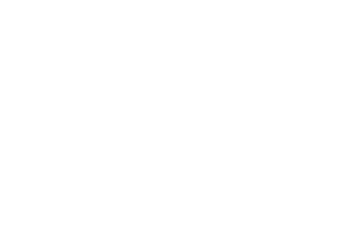

In [198]:
_ = sklearn.tree.plot_tree(regressor)

In [202]:
splitter=['best', 'random']
max_depth=[2,5,1]

In [203]:
best_variables=pd.DataFrame()
for i in max_depth:
    for s in splitter:
        regressor = DecisionTreeRegressor(max_depth=i,splitter=s,random_state=123)

        cv_results = cross_validate(regressor, x_norm, y, cv=10)
        sorted(cv_results)
        
        best_variables1=pd.DataFrame({'głębokość drzewa': [i],
                                     'strategia': [s],
                                     'scorer':[cv_results['test_score']]})

        best_variables=pd.concat([best_variables,best_variables1])

In [204]:
best_variables.head(1)

,głębokość drzewa,strategia,scorer
0,2,best,"[0.2656837031469206, 0.29133677956438375, 0.28..."


In [188]:
best_variables['scorer'].mean()

array([0.24439716, 0.27508739, 0.26420633, 0.45554724, 0.05911779,
       0.24699376, 0.23109861, 0.12068058, 0.03591545, 0.09176676])

model drzewa decyzyjnego nie spełnił swojego zadania, za słabe dopasowanie

**las losowy**

In [53]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from sklearn.model_selection import  cross_val_score

In [54]:
from sklearn.model_selection import GridSearchCV

params = {
    # "min_samples_split": range(2, 21, 2),
    # "min_samples_leaf": range(1, 21, 2),
      "n_estimators": range(2,100,1),
      "max_depth": range(3, 6, 3),
      "criterion": ['mse']
 }

forest = RandomForestRegressor()
rf_regressor_search = GridSearchCV(forest, params, cv=5)
rf_regressor_search.fit(train_x, train_y)
rf_regressor_search.best_params_

KeyboardInterrupt: 

In [225]:
value_rf=list(rf_regressor_search.best_params_.values())

estymator=value_rf[2]
depth=value_rf[1]

In [52]:
best_rf_regressor = \
    RandomForestRegressor(n_estimators=estymator, max_depth=depth, criterion='mse')
best_rf_regressor.fit(train_x, train_y)
best_rf_regressor.score(test_x, test_y)
best_rf_regressor.mse(test_x, test_y)

NameError: name 'RandomForestRegressor' is not defined